In [ ]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt

import keras
from keras.layers import LeakyReLU, UpSampling1D, Input, Reshape, Activation, Lambda, AveragePooling1D,AveragePooling2D
from keras.layers import Convolution2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import RMSprop
import random

# From pypng
import png
#from sklearn.p

FONTSIZE = 18
FIGURE_SIZE = (10,4)
FIGURE_SIZE2 = (10,10)

# Configure parameters
plt.rcParams.update({'font.size': FONTSIZE})

####################################
# 
import re

##################
# Default tick label size
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

from hw4_tools import *


In [ ]:
#Function for generating list of images of respective parts.
def make_df(file, coloumn_name, code, new_coloumn_entry):
    image_names = []
    check_for = file[coloumn_name] == code
    file_data = file[check_for]
    file_data['Lesion_typename'] = new_coloumn_entry
    return(file_data)

#Function for generating training, validation and test sets list of images of respective parts.
def sets(image_names):
    train_length = len(image_names) * 0.7
    int_train_length = int(train_length)
    val_length = int_train_length + len(image_names) * 0.15
    int_val_length = int(val_length)
    trainset = image_names[:int_train_length]
    valset = image_names[int_train_length:int_val_length]
    testset = image_names[int_val_length:]
    return (trainset, valset, testset)

#Function for generating lists of imagenames and labels for trainset, valset and testset.
def make_list(Full_list, data_length):
    image_name = []
    image_label = []
    #Storing annotated image file names in a list (image_name).
    for i in range (data_length):
        image_name.append(Full_list['File_name'].values[i])
    #Storing annotated image label names in a list (image_label).
    for i in range (data_length):
        image_label.append(Full_list['Coarse_lesion_type'].values[i])
    return (image_name, image_label)

#Function for reading each image file and returning a 3-dimensional array.
def Read_image(image_name):
    read_image = png.Reader(image_name)
    image_copy = read_image.read()
    image_in_2d = np.vstack(map(np.uint8, image_copy[2]))
    image_in_3d = np.reshape(image_in_2d, (image_copy[0],image_copy[1],image_copy[3]['planes'])) / 512.0
    return image_in_3d

#Function for reading each image file from given directory using given image name list and returning a array.
def Image_directory(directory, image_name):
    print(directory, image_name)
    #Get all of the file names
    all_images = sorted(os.listdir(directory))
    list_of_images = [Read_image(directory + "/" + i) for i in all_images if re.search(image_name, i) ]    
    return np.array(list_of_images, dtype=np.float32)

def training_set_generator(ins, outs, batch_size=10,
                      input_name='input_input', 
                      output_name='output'):
    while True:
        example_indices = random.choices(range(ins.shape[0]), k=batch_size)
        yield({input_name: ins[example_indices,:,:,:]},
             {output_name: outs[example_indices]})


In [ ]:
#Reading file with file name and labels.

#Storing the images in directory.
directory = '/home2/potd0000/project/Key_slices/'

#data information extraction from csv file
Entire_image_list = pd.read_csv(r'/home2/potd0000/project/Dl_info.csv')
#Removing all other coloumns and only selecting Filename, Coarse_lesion_type and, Image_size to be there in dataframe.
list_filename_n_type = Entire_image_list[['File_name', 'Coarse_lesion_type', 'Image_size']]

#Eliminating 40 image names which is not of size '512 x 512'
check_for_size = list_filename_n_type['Image_size'] == '512, 512'
list_filename_n_type = list_filename_n_type[check_for_size]

#Taking a small data set
# Bone_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 1, 'Bone').sample(n=24)
# Abdomen_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 2, 'Abdomen').sample(n=221)
# Mediastinum_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 3, 'Mediastinum').sample(n=167)
# Liver_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 4, 'Liver').sample(n=134)
# Lung_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 5, 'Lung').sample(n=246)
# Kidney_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 6, 'Kidney').sample(n=50)
# Soft_tissue_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 7, 'Soft_tissue').sample(n=69)
# Pelvis_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 8, 'Pelvis').sample(n=89)

Bone_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 1, 'Bone')
Abdomen_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 2, 'Abdomen')
Mediastinum_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 3, 'Mediastinum')
Liver_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 4, 'Liver')
Lung_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 5, 'Lung')
Kidney_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 6, 'Kidney')
Soft_tissue_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 7, 'Soft_tissue')
Pelvis_image_names = make_df(list_filename_n_type, 'Coarse_lesion_type', 8, 'Pelvis')



trainset_Bone, valset_Bone, testset_Bone = sets(Bone_image_names)
trainset_Abdomen, valset_Abdomen, testset_Abdomen = sets(Abdomen_image_names)
trainset_Mediastinum, valset_Mediastinum, testset_Mediastinum = sets(Mediastinum_image_names)
trainset_Liver, valset_Liver, testset_Liver = sets(Liver_image_names)
trainset_Lung, valset_Lung, testset_Lung = sets(Lung_image_names)
trainset_Kidney, valset_Kidney, testset_Kidney = sets(Kidney_image_names)
trainset_Soft_tissue, valset_Soft_tissue, testset_Soft_tissue = sets(Soft_tissue_image_names)
trainset_Pelvis, valset_Pelvis, testset_Pelvis = sets(Pelvis_image_names)

training_name_df = pd.DataFrame(trainset_Bone)
training_name_df = training_name_df.append(trainset_Abdomen)
training_name_df = training_name_df.append(trainset_Mediastinum)
training_name_df = training_name_df.append(trainset_Liver)
training_name_df = training_name_df.append(trainset_Lung)
training_name_df = training_name_df.append(trainset_Kidney)
training_name_df = training_name_df.append(trainset_Soft_tissue)
training_name_df = training_name_df.append(trainset_Pelvis)

validation_name_df = pd.DataFrame(valset_Bone)
validation_name_df = validation_name_df.append(valset_Abdomen)
validation_name_df = validation_name_df.append(valset_Mediastinum)
validation_name_df = validation_name_df.append(valset_Liver)
validation_name_df = validation_name_df.append(valset_Lung)
validation_name_df = validation_name_df.append(valset_Kidney)
validation_name_df = validation_name_df.append(valset_Soft_tissue)
validation_name_df = validation_name_df.append(valset_Pelvis)

testing_name_df = pd.DataFrame(testset_Bone)
testing_name_df = testing_name_df.append(testset_Abdomen)
testing_name_df = testing_name_df.append(testset_Mediastinum)
testing_name_df = testing_name_df.append(testset_Liver)
testing_name_df = testing_name_df.append(testset_Lung)
testing_name_df = testing_name_df.append(testset_Kidney)
testing_name_df = testing_name_df.append(testset_Soft_tissue)
testing_name_df = testing_name_df.append(testset_Pelvis)

trainset_length = len(training_name_df)
valset_length = len(validation_name_df)
testset_length = len(testing_name_df)


training_image_name, training_image_label = make_list(training_name_df, trainset_length)
validation_image_name, validation_image_label = make_list(validation_name_df, valset_length)
testing_image_name, testing_image_label = make_list(testing_name_df, testset_length)


In [ ]:
train_image_data_list = []

for names in training_image_name:
    train_image_data_list.extend(Image_directory(directory, names))
input_train_image = np.array(train_image_data_list)
input_train_image.shape
np.save('input_train_image_data_small', input_train_image)


val_image_data_list = []

for names in validation_image_name:
    val_image_data_list.extend(Image_directory(directory, names))
input_val_image = np.array(val_image_data_list)
input_val_image.shape
np.save('input_val_image_data_small', input_val_image)


test_image_data_list = []

for names in testing_image_name:
    test_image_data_list.extend(Image_directory(directory, names))
input_test_image = np.array(test_image_data_list)
input_test_image.shape
np.save('input_test_image_data_small', input_test_image)

In [ ]:
input_train_image_saved = np.load('input_train_image_data_small.npy')
input_val_image_saved = np.load('input_val_image_data_small.npy')
input_test_image_saved = np.load('input_test_image_data_small.npy')

In [ ]:
input_train_image_saved = np.load('input_train_image_data.npy')
input_val_image_saved = np.load('input_val_image_data.npy')
input_test_image_saved = np.load('input_test_image_data.npy')

In [ ]:
from sklearn.preprocessing import label_binarize

trainset_length = len(training_name_df)
valset_length = len(validation_name_df)
testset_length = len(testing_name_df)


training_image_name, training_image_label = make_list(training_name_df, trainset_length)
validation_image_name, validation_image_label = make_list(validation_name_df, valset_length)
testing_image_name, testing_image_label = make_list(testing_name_df, testset_length)

training=input_train_image_saved
train_label= np.array(training_image_label)
train_label=label_binarize(train_label, classes=[1,2,3,4,5,6,7,8])

validation=input_val_image_saved
val_label= np.array(validation_image_label)
val_label=label_binarize(val_label, classes=[1,2,3,4,5,6,7,8])

testing=input_test_image_saved
test_label=np.array(testing_image_label)
test_label = label_binarize(test_label, classes=[1,2,3,4,5,6,7,8])

In [ ]:
#Model Uma
def construct_model(input_shape, lambda_regularization=0):
    # A sequential model is defined with 3 convolutional layers, maxpooling, dropouts 
    # 2 dense layers with their drouputs and an output layer form the sequential model
    model = Sequential()
    # Adding 5 convolutional layers with (5,5) filters and l2 regularization
    model.add(Convolution2D(filters=10,
                            input_shape=input_shape,
                           kernel_size=(3,3),
                           strides= 3,
                           padding='same',
                            use_bias= False,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C0'
                           ))
    
    # Maxpooling layers with (3,3) strides
    model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), name='C1'))
    
    model.add(Convolution2D(filters=20,
                            input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=1,
                           padding='same',
                            use_bias= False,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C2'
                           ))
    model.add(AveragePooling2D(pool_size = (3,3),strides=(3,3), padding='same'))
    #Batch normalisation
    model.add(BatchNormalization(axis= 1, momentum=0.99, epsilon=0.001, scale=True))
    
    model.add(Convolution2D(filters=30,
                            input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=1,
                           padding='same',
                            use_bias= False,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C3'
                           ))
    model.add(AveragePooling2D(pool_size = (3,3),strides=(3,3), padding='same'))
    
    model.add(Convolution2D(filters=40,
                            input_shape=input_shape,
                           kernel_size=(1,1),
                           strides=1,
                           padding='same',
                            use_bias= False,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C4'
                           ))
    
    # Dropout of 0.7 is added before the maxpooling to avoid overfitting and to improve the efficiency
    #model.add(Dropout(rate = 0.7))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(3,3), name='C5'))
    
    model.add(Convolution2D(filters=10,
                            input_shape=input_shape,
                           kernel_size=(5,5),
                           strides=1,
                           padding='same',
                            use_bias=False,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='elu', name='C6'
                           ))
    # A 0.5 dropout is added so that a few neurons can be overlooked
    #model.add(Dropout(rate = 0.5))
    #model.add(MaxPooling2D(pool_size=(3,3), strides=(1,1), name='C7'))
    
    # Flatten layer for coverting the output of the covolutiuonal layer to a an array
    model.add(Flatten())
    
    #  Two input dense Layers are adeed 
    model.add(Dense(units = 100,
                   activation = 'elu',
                   use_bias = True,
                   kernel_initializer = 'random_uniform',
                   bias_initializer = 'random_uniform',
                   kernel_regularizer = keras.regularizers.l2(lambda_regularization), 
                   bias_regularizer = keras.regularizers.l2(lambda_regularization)
                   ))
    #model.add(Dropout(rate = 0.7))
    model.add(Dense(units = 50,
                   activation = 'elu',
                   use_bias = True,
                   kernel_initializer = 'random_uniform',
                   bias_initializer = 'random_uniform',
                   kernel_regularizer = keras.regularizers.l2(lambda_regularization), 
                   bias_regularizer = keras.regularizers.l2(lambda_regularization)
                   ))
    # Output layer is a dense layer with regularisation and a sigmoidal activation
    model.add(Dense(units = 8,
                   activation = 'relu',
                   use_bias = True,
                   kernel_initializer = 'random_uniform',
                   bias_initializer = 'random_uniform',
                   kernel_regularizer = keras.regularizers.l2(lambda_regularization), 
                   bias_regularizer = keras.regularizers.l2(lambda_regularization),
                   name = 'output' 
                   ))
    
    
    # The optimizer determines how the gradient descent is to be done
    #opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, 
     #                       epsilon=None, decay=0.0, amsgrad=False)

    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)
    # Compiling the model with the optimisers and using accuracy as a metric for the model
    model.compile(loss='binary_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
#Model Akhil
def construct_model(input_shape, lambda_regularization=0):
    model = Sequential()
    
    model.add(Convolution2D(filters=20,
                            input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=2,
                           padding='same',
                            use_bias=True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C0'
                           ))
    
    model.add(MaxPooling2D(pool_size=(3,3), strides=(1,1), name='MP0'))
    
    model.add(BatchNormalization(axis= 1, momentum=0.99, epsilon=0.001, scale=True))
    #keras.layers.BatchNormalization(axis=1, scale=True)
    
    model.add(Convolution2D(filters=50,
                            input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=3,
                           padding='same',
                            use_bias=True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C1'
                           ))
    
    model.add(MaxPooling2D(pool_size=(5,5), strides=(3,3), name='MP1'))
     
    model.add(Convolution2D(filters=20,
                            input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=3,
                           padding='same',
                            use_bias=True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C2'
                           ))
    
    model.add(BatchNormalization(axis= 1, momentum=0.99, epsilon=0.001, scale=True))
#     model.add(MaxPooling2D(pool_size=(5,5), strides=(3,3), name='MP2'))
    
    model.add(Convolution2D(filters=20,
                            input_shape=input_shape,
                           kernel_size=(3,3),
                           strides=3,
                           padding='same',
                            use_bias=True,
                           kernel_initializer='random_uniform',
                           bias_initializer='random_uniform',
                            kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                            bias_regularizer=keras.regularizers.l2(lambda_regularization),
                            activation='relu', name='C3'
                           ))
    
    #model.add(MaxPooling2D(pool_size=(5,5), strides=(3,3), name='MP2'))
     
    model.add(Flatten())
    
       
    model.add(Dense(units=100,
                    input_shape=input_shape,
                   activation='relu',
                    use_bias=True,
                    kernel_initializer='random_uniform',
                    bias_initializer='random_uniform',
                    kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                    bias_regularizer=keras.regularizers.l2(lambda_regularization)
                   ))
    
    model.add(Dense(units=200,
                   activation='relu',
                    use_bias=True,
                    kernel_initializer='random_uniform',
                    bias_initializer='random_uniform',
                    kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                    bias_regularizer=keras.regularizers.l2(lambda_regularization)
                   ))
    
    #dropout
    #model.add(Dropout(0.2))
    
    model.add(Dense(units=8,
                   activation='sigmoid',
                    use_bias=True,
                    kernel_initializer='random_uniform',
                    bias_initializer='random_uniform',
                    name='output',
                    kernel_regularizer=keras.regularizers.l2(lambda_regularization),
                    bias_regularizer=keras.regularizers.l2(lambda_regularization)
                   ))
    
    
    # The optimizer determines how the gradient descent is to be done
    opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, 
                  metrics=['accuracy'])
    print(model.summary())
    return model


In [ ]:
model = construct_model(input_train_image_saved.shape[1:])

In [ ]:
def modelrun(reg_param):
    model = construct_model(input_train_image_saved.shape[1:],reg_param)
    generator = training_set_generator(training,train_label,batch_size=10,
                                  input_name='C0_input')
    model.fit_generator(generator, epochs=1000, steps_per_epoch=10,
                    validation_data=(validation, val_label))
    y=model.predict(testing)
    fpr,tpr,roc_auc=plotting(y)
    return fpr,tpr,roc_auc

In [ ]:
def tuning(regularization_param_list):
    for y in regularization_param_list:
        for x in Ntraining_list:
            final_fvaf[c,:]=modelrun(y)
            c+=1

In [ ]:
generator = training_set_generator(training,train_label,batch_size=10,
                                  input_name='C0_input')

In [ ]:
model.fit_generator(generator, epochs=1000, steps_per_epoch=10,
                    validation_data=(validation, val_label))

In [ ]:
from keras.models import load_model

#model.save('akhil_model_small.h5')  # creates a HDF5 file 'my_model.h5'
#model.save('uma_model_big.h5')  # creates a HDF5 file 'my_model.h5'
model.save('akhil_model_bigg.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one

In [29]:
#https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
def plotting(y_score):
    #https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc

    # Plot linewidth.
    lw = 2
    n_classes = 8
    classes={0:"Bone",1:"Abdomen",2:"Mediastinum",3:"Liver",4:"Lung",
              5:"Kidney",6:"Soft Tissue",7:"Pelvis"}
    y_score=y_score
    y_test=test_label
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig = plt.figure()
    ax = plt.subplot(111)

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)


    for key,bodypart in classes.items():
        ax.plot(fpr[key], tpr[key],
                 label='ROC for {0} (area = {1:0.2f})'
                 ''.format(bodypart, roc_auc[key]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for each body part')
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    return ax
    plt.savefig('small_akhil.png')



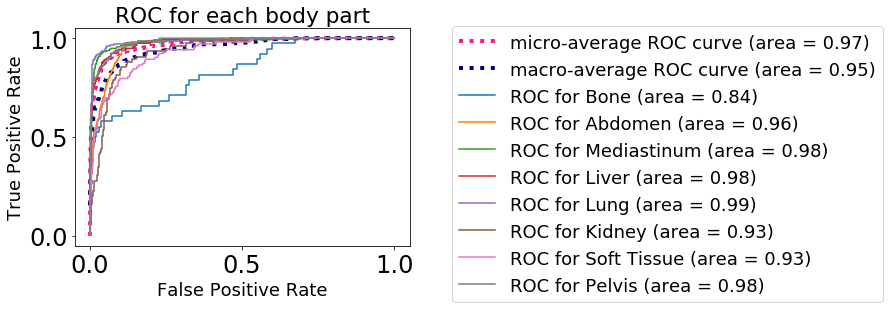

In [30]:
from keras.models import load_model
model = load_model('akhil_model_bigg.h5')
#y=model.predict(testing)
ax=plotting(y)
plt.show()

In [ ]:
layer_list=['C0', 'C1']
activations = intermediate_model_state(model, validation, layer_list)
example=25

In [ ]:
plt.imshow(validation[example,:,:,:])
visualize_state(activations[0], width=10, example=example)
visualize_state(activations[1], width=20, example=example)

In [ ]:
show_predictions(model, training, width=3,figsize=(12,12), indices=[0,10,20,30,40,50])

In [ ]:
#https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
def plotting(y_score):
    #https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc

    # Plot linewidth.
    lw = 2
    n_classes = 8
    classes={0:"Bone",1:"Abdomen",2:"Mediastinum",3:"Liver",4:"Lung",
              5:"Kidney",6:"Soft Tissue",7:"Pelvis"}
    y_score=y_score
    y_test=test_label
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr = all_fpr
    tpr = mean_tpr
    roc_auc = auc(fpr, tpr)

    # Plot all ROC curves
    fig = plt.figure()
    ax = plt.subplot(111)

    plt.plot(fpr, tpr,
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc),
             color='navy', linestyle=':', linewidth=4)


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for each body part')
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    return fpr,tpr,roc_auc
    plt.savefig('small_akhil.png')



In [ ]:
for y in regularization_param_list:
        for x in Ntraining_list:
            final_fvaf[c,:]=input_part2(MI,torque,x,y)
            c+=1